In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from IPython.display import clear_output
from collections import defaultdict

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from utils import (
    read_pkl, 
    find_quadrant_id_from_keys,
    read_bootstrap_txt,
    extract_carpet_data,
    decorate_fig_carpetplot,
    get_roi_colour_codes,
    set_base_dir,
    CARPET_PLOTS, SCRATCH_DIR, PICKLE_DIR,MAIN,
    TimeSeries,
    change_font,
)
change_font()

Create subject level carpet plots in `CARPET_PLOTS`

Settings

In [2]:
datadir = SCRATCH_DIR
n_bootstraps = 400
bootstrap_id = 0
window_size = (39, 219)
close_figures = True

experiment_id = "1_frequency_tagging" 
normal_3T_sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009"] 
normal_7T_sub_ids = ["Pilot001", "Pilot009", "Pilot010", "Pilot011"]
vary_sub_ids = ["020"]*3 + ["021"]*3
vary_task_ids = [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]]

sub_ids = normal_3T_sub_ids*2 + normal_7T_sub_ids + vary_sub_ids*3*2
experiment_ids = ["1_frequency_tagging"]*len(normal_3T_sub_ids)*2 + ["1_attention"]*len(normal_7T_sub_ids) + ["1_frequency_tagging"]*len(vary_sub_ids)*3*2
mri_ids = ["3T"]*len(normal_3T_sub_ids)*2 + ["7T"]*len(normal_7T_sub_ids) + ["3T"]*len(vary_sub_ids)*3 + ["7T"]*len(vary_sub_ids)*3
roi_task_ids= ["entrain"]*len(normal_3T_sub_ids) + ["entrain"]*len(normal_3T_sub_ids) + ['AttendAway']*len(normal_7T_sub_ids) + (["entrainA"]*3 + ["entrainD"]*3 + ["entrainB"]*3 + ["entrainE"]*3 + ["entrainC"]*3 + ["entrainF"]*3) * 2
task_ids= ["control"]*len(normal_3T_sub_ids) + ["entrain"]*len(normal_3T_sub_ids) + ['AttendAway']*len(normal_7T_sub_ids) + vary_task_ids*3*2
roi_frequencies = [[.125, .2]]*(len(normal_3T_sub_ids)*2+len(normal_7T_sub_ids)) + ([[.125,.2]]*3 + [[.125,.2]]*3 + [[.125,.175]]*3 + [[.15,.2]]*3 + [[.125,.15]]*3 + [[.175,.2]]*3) * 2
task_frequencies = [[.125, .2]]*(len(normal_3T_sub_ids)*2+len(normal_7T_sub_ids)) + [[.125,.2],[.125,.175],[.125,.15],[.125,.2],[.15,.2],[.175,.2]]*3*2

TR = .3
fos = [.8]
pvals = ["uncp"]
fig_out_dir = Path(set_base_dir(str(CARPET_PLOTS)))
stim_start = 14
cmap = "Greys_r"
vmin, vmax = -1.31, 1.31

for i in [sub_ids, experiment_ids, mri_ids, roi_task_ids, task_ids, roi_frequencies, task_frequencies]:
    print(len(i))

58
58
58
58
58
58
58


In [3]:
def calculate_rmse(time_series, desired_freq, sampling_rate):
    n = len(time_series)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    
    # Perform FFT
    fft_values = np.fft.fft(time_series)
    
    # Find the index of the desired frequency
    target_idx = np.argmin(np.abs(freqs - desired_freq))
    
    # Isolate the desired frequency component
    filtered_fft = np.zeros_like(fft_values)
    filtered_fft[target_idx] = fft_values[target_idx]
    filtered_fft[-target_idx] = fft_values[-target_idx]  # also include the complex conjugate
    
    # Reconstruct the time series with only the desired frequency
    reconstructed_signal = np.fft.ifft(filtered_fft)
    
    # Calculate the error
    error = time_series - reconstructed_signal
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean(np.abs(error)**2))
    
    return rmse


def calculate_rmse_across_ts_data(ts_data,f1_count,f1f2_count,f2_count,f1,f2,TR=.3,n_permutations=1,nperseg=580):

    assert len(ts_data)==4
    assert all(ts_data[0].shape[-1] == ts.shape[-1] for ts in ts_data[1:4])
    assert f1_count+f1f2_count+f2_count == ts_data[0].shape[-1]

    frequencies = [f1,f2]

    observed_rmse = defaultdict(list)

    for ts_type, _ts_data in zip(
        ["raw", "windowed", "denoised", "denoisedrephased"],
        ts_data
    ):
        begin_idx = 0
        for f_type, test_f_types, test_frequencies, f_count in zip(
            ["f1","multiplex","f2"],
            [["f1"],["f1","f2"],["f2"]],
            [[frequencies[0]], frequencies, [frequencies[1]]], 
            [f1_count,f1f2_count,f2_count]
        ):
            end_idx = begin_idx + f_count
            ts_data_per_f = _ts_data[:,begin_idx:end_idx]
            begin_idx = end_idx

            for i in range(ts_data_per_f.shape[-1]):
                raw_timeseries = ts_data_per_f[:,i]
                for foi_type, foi in zip(test_f_types,test_frequencies):
                    rmse = calculate_rmse(raw_timeseries, foi, 1/TR)
                    observed_rmse[f"ts-{ts_type}_roi-{f_type}_f-{foi_type}"].append(rmse)

    return observed_rmse

Run

In [ ]:
for fo, pval in itertools.product(fos,pvals):
        
    rmse_pkl = PICKLE_DIR / f"preprocess_steps_rmse_fo-{fo}_pval-{pval}.pkl"
    rmse_dict = defaultdict(list)
    for experiment_id, mri_id, sub_id, roi_task_id, task_id, frequencies, _task_frequencies in zip(
        experiment_ids, mri_ids, sub_ids, roi_task_ids, task_ids, roi_frequencies, task_frequencies,
    ):

        f_data = {}
        for roi_f in frequencies:
            f_data[roi_f] = read_pkl(
                datadir, 
                n_bootstraps, 
                sub_id, 
                roi_task_id, 
                roi_f, 
                task_id,
                experiment_id=experiment_id,
                mri_id=mri_id,
                pval=pval,
                fo=fo,
            )

        task_quadrant = find_quadrant_id_from_keys(f_data[frequencies[0]], task_id)
                
        assert frequencies[1]>frequencies[0]
        f1_dict = f_data[frequencies[0]].copy()
        f2_dict = f_data[frequencies[1]].copy()
        f1_coords = f1_dict['roi_coords']
        f2_coords = f2_dict['roi_coords']
        f1_only_coords = f1_coords.astype(int) + f2_coords.astype(int)
        f1_only_coords = f1_only_coords[f1_coords]
        f2_only_coords = f1_coords.astype(int) + f2_coords.astype(int)
        f2_only_coords = f2_only_coords[f2_coords]
        # Masks
        inter_from_f1 = f1_only_coords == 2
        f1_from_f1 = f1_only_coords == 1
        f2_from_f2 = f2_only_coords == 1
        n_f1, n_f1f2, n_f2 = f1_from_f1.sum(), inter_from_f1.sum(), f2_from_f2.sum()

        # Load data from nifti
        # 1) untruncated, 2) preprocessed
        bootstrap_txt = Path(f"/scratch/fastfmri/experiment-{experiment_id}_mri-{mri_id}_smooth-0_truncate-{window_size[0]}-{window_size[1]}_n-25_batch-00_desc-basic_pval-{pval}_bootstrap/sub-{sub_id}/task-{task_id}{task_quadrant}_test_splits.txt")
        assert bootstrap_txt.exists(), f"{bootstrap_txt} not found."
        data_from_dtseries_raw, data_from_dtseries_windowed, data_from_dtseries_preprocessed = read_bootstrap_txt(bootstrap_txt, bootstrap_id) # Load single bootstrap

        data_from_dtseries_raw = np.hstack(
            [
                data_from_dtseries_raw[f1_coords,:][f1_from_f1,:].T,
                data_from_dtseries_raw[f1_coords,:][inter_from_f1,:].T,
                data_from_dtseries_raw[f2_coords,:][f2_from_f2,:].T,
            ]
        )
        data_from_dtseries_windowed = np.hstack(
            [
                data_from_dtseries_windowed[f1_coords,1:][f1_from_f1,:].T,
                data_from_dtseries_windowed[f1_coords,1:][inter_from_f1,:].T,
                data_from_dtseries_windowed[f2_coords,1:][f2_from_f2,:].T,
            ]
        )
        data_from_dtseries_preprocessed = np.hstack(
            [
                data_from_dtseries_preprocessed[f1_coords,1:][f1_from_f1,:].T,
                data_from_dtseries_preprocessed[f1_coords,1:][inter_from_f1,:].T,
                data_from_dtseries_preprocessed[f2_coords,1:][f2_from_f2,:].T,
            ]
        )
        # Load data from pickle
        # 3) preprocessed, 4) preprocessed & phased
        _, f1_data_from_pkl_preprocessed = extract_carpet_data(f1_dict, task_id, task_quadrant, bootstrap_id, False)
        f1_phased_tps, f1_data_from_pkl_preprocessed_phased = extract_carpet_data(f1_dict, task_id, task_quadrant, bootstrap_id, True)
        _, f2_data_from_pkl_preprocessed = extract_carpet_data(f2_dict, task_id, task_quadrant, bootstrap_id, False)
        f2_phased_tps, f2_data_from_pkl_preprocessed_phased = extract_carpet_data(f2_dict, task_id, task_quadrant, bootstrap_id, True)
        intersected_phased_tps = [i for i in set(f1_phased_tps).intersection(f2_phased_tps)]
        f1_phased_tp_mask = [tp in intersected_phased_tps for tp in f1_phased_tps]
        f2_phased_tp_mask = [tp in intersected_phased_tps for tp in f2_phased_tps]

        data_from_pkl_preprocessed = np.hstack(
            [
                f1_data_from_pkl_preprocessed[:,f1_from_f1],
                f1_data_from_pkl_preprocessed[:,inter_from_f1],
                f2_data_from_pkl_preprocessed[:,f2_from_f2],
            ]
        )
        data_from_pkl_preprocessed_phased = np.hstack(
            [
                f1_data_from_pkl_preprocessed_phased[:,f1_from_f1][f1_phased_tp_mask,:],
                f1_data_from_pkl_preprocessed_phased[:,inter_from_f1][f1_phased_tp_mask,:],
                f2_data_from_pkl_preprocessed_phased[:,f2_from_f2][f2_phased_tp_mask,:],
            ]
        )

        ts_labels = [
            "raw", "windowed", "denoised", "denoised_rephased"
        ]
        ts_data = [
            data_from_dtseries_raw, 
            data_from_dtseries_windowed,
            data_from_dtseries_preprocessed,
            #data_from_pkl_preprocessed, 
            data_from_pkl_preprocessed_phased,
        ]

        rmse_across_data_processing_steps = calculate_rmse_across_ts_data(ts_data,f1_from_f1.sum(),inter_from_f1.sum(),f2_from_f2.sum(),frequencies[0],frequencies[1])

        for k, v in rmse_across_data_processing_steps.items():

            rmse_dict["experiment_id"].append(experiment_id)
            rmse_dict["mri_id"].append(mri_id)
            rmse_dict["sub_id"].append(sub_id)
            rmse_dict["roi_task_id"].append(roi_task_id)
            rmse_dict["task_id"].append(task_id)
            
            ts_processing_step = k.split('ts-')[-1].split("_")[0]
            frequency_of_roi = k.split('roi-')[-1].split("_")[0]
            frequency_of_interest = k.split("-")[-1]
            rmse = np.array(v)

            rmse_dict["ts_processing_step"].append(ts_processing_step)
            rmse_dict["frequency_of_roi"].append(frequency_of_roi)
            rmse_dict["frequency_of_interest"].append(frequency_of_interest)
            rmse_dict["rmse"].append(rmse)
            

        # Get sorting order based on `data_from_dtseries_preprocessed`
        # Sort for each set of vertices: f1, f1f2, and f2 (this is the order that the reoriented data)
        # Note: `data_from_dtseries_preprocessed` == `data_from_pkl_preprocessed`

        # This will error out if there is any of f1, f2, or f1f2 has 0 vertices.. I THINK?
        y = data_from_dtseries_preprocessed.copy()
        y = (( y - y.mean(0)) / y.std(0) ).T
        sorted_voxels = {}
        y_f1 = y[:n_f1,:].copy()
        y_f1f2 = y[n_f1:n_f1+n_f1f2,:].copy()
        y_f2 = y[n_f1+n_f1f2:,:].copy()
        for f_group, y in zip(["f1","f1f2","f2"], [y_f1, y_f1f2, y_f2]):
            C = np.corrcoef(y)
            correlation_strength = np.abs(C).sum(axis=1)
            sorted_voxels[f_group] = np.argsort(correlation_strength)[::-1]

        for y_ix, (y_label, y) in enumerate(zip(ts_labels, ts_data)):
            
            fig, ax = plt.subplots(
                nrows=1,ncols=1, figsize=(2.,1.2), dpi=300,
                #gridspec_kw=dict(height_ratios=[286, 119]),
            )
            
            y = (( y - y.mean(0)) / y.std(0) ).T

            # Sort
            y[:n_f1, :] = y[:n_f1,:][sorted_voxels["f1"],:]
            y[n_f1:n_f1+n_f1f2, :] = y[n_f1:n_f1+n_f1f2,:][sorted_voxels["f1f2"],:]
            y[n_f1+n_f1f2:, :] = y[n_f1+n_f1f2:,:][sorted_voxels["f2"],:]

            im = ax.imshow(y, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
            if y_ix == 0:
                for i in window_size:
                    ax.plot([i/TR]*2,[0,n_f1+n_f2+n_f1f2], color='orange', linestyle='-', linewidth=1)
                ax.plot([stim_start/TR]*2,[0,n_f1+n_f2+n_f1f2], color='lightgreen', linestyle='-', linewidth=1)
            if y_label == "raw":
                n_pos=160
            else:
                n_pos=120
            fig, ax = decorate_fig_carpetplot(y,fig, ax, im, _task_frequencies[0], _task_frequencies[1], n_f1, n_f2, n_f1f2, FONTSIZE=8, TR=TR,n_pos=n_pos)

            fig.tight_layout()

            png_out = fig_out_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_task-{roi_task_id}_task-{task_id}_pval-{pval}_fo-{fo}_{y_ix}{y_label}.png"
            fig.savefig(png_out, dpi='figure')

            #if y_label == "denoised" and task_id == "entrain":
                #import pdb; pdb.set_trace()

            if close_figures:
                plt.close()


        clear_output()

    rmse_df = pd.DataFrame(rmse_dict)
    rmse_df.to_pickle(rmse_pkl)

read rmse pickle

In [4]:
fo = 0.8
pval = "uncp"
rmse_pkl = PICKLE_DIR / f"preprocess_steps_rmse_fo-{fo}_pval-{pval}.pkl"
if rmse_pkl.exists():
    rmse_df = pd.read_pickle(rmse_pkl)
    rmse_df["task_same_as_roi_task"] = rmse_df.roi_task_id == rmse_df.task_id
else:
    raise ValueError(f"{rmse_pkl} does not exist.")

In [5]:
from scipy.stats import wilcoxon
linewidth = .5
FONTSIZE = 8

In [28]:
sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009", "Pilot001", "Pilot009", "Pilot010", "Pilot011"] + ["020"]*3+["021"]*3 + ["020"]*3+["021"]*3
mri_ids = ["3T", "3T", "3T", "3T", "3T", "3T", "3T", "3T", "3T", "7T", "7T", "7T", "7T"] + ["3T"]*6 + ["7T"]*6
task_ids = ["entrain"] * 9 + ["AttendAway"] * 4 + ["entrainA", "entrainB", "entrainC", "entrainD", "entrainE", "entrainF"] * 2

for sub_id, mri_id, task_id in zip(sub_ids, mri_ids, task_ids):

    fig, ax = plt.subplots(figsize=(3,1.2), dpi=300, layout="constrained")

    pvals = []
    boxplot = []
    for ax_ix, (frequency_of_roi, frequency_of_interest) in enumerate(zip(["f1","f2","multiplex","multiplex"], ["f1","f2"]*2)):

        # Expect denoised < windowed => windowed - denoised > 0
        windowed_data = rmse_df[(rmse_df.ts_processing_step=="windowed") & (rmse_df.task_id==task_id) & (rmse_df.task_same_as_roi_task) & (rmse_df.sub_id==sub_id) & (rmse_df.mri_id==mri_id) & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest)]["rmse"].values[0]
        denoised_data = rmse_df[(rmse_df.ts_processing_step=="denoised") & (rmse_df.task_id==task_id) & (rmse_df.task_same_as_roi_task) & (rmse_df.sub_id==sub_id) & (rmse_df.mri_id==mri_id) & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest)]["rmse"].values[0]

        pval = wilcoxon(windowed_data,denoised_data).pvalue
        windowed_sub_denoised = windowed_data - denoised_data

        pvals.append(pval)
        boxplot.append(windowed_sub_denoised)

    # Boxplot
    box = ax.boxplot(boxplot, showfliers=False, whis=1.5, widths=linewidth)

    # Add significance
    q3_offset = .1
    for i,pval in zip(range(4),pvals):
        q1 = box['boxes'][i].get_ydata()[1]
        q3 = box['boxes'][i].get_ydata()[3]
        iqr = q3-q1
        ypos = (iqr*1.5 + q3)
        #ypos = q3
        pval_txt = "*"
        if pval >= .05:
            pval_txt = "n.s."
        ax.text(i+1, ypos, pval_txt, ha='center', va='bottom', fontsize=FONTSIZE)


    for spine_type in ("top","right","bottom"):
        ax.spines[spine_type].set_visible(False)

    ax.spines.left.set_linewidth(linewidth)
    ax.spines.left.set_position(("outward", 1))
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["$f_1$ in $f_1$", "$f_2$ in $f_2$", "$f_1$ in\nmultiplex", "$f_2$ in\nmultiplex"], rotation=0, fontsize=FONTSIZE)
    ax.set_xlabel("Frequency-encoded region", fontsize=FONTSIZE)

    ax.set_ylabel("$\Delta$RMSE", fontsize=FONTSIZE)

    ax.set_title(f"Windowed-Denoised, {mri_id}, sub-{sub_id}", fontsize=FONTSIZE, pad=10)
    ax.axhline(0, color="k",linestyle="dotted", lw=.5,zorder=0) 
    ax.tick_params(axis='y', which='both', labelsize=FONTSIZE, width=linewidth, pad=0)
    ax.tick_params(axis='x', which='both', labelsize=FONTSIZE-2, width=linewidth, pad=0, length=0)


    if sub_id == "Pilot001":
        fig.savefig(MAIN / f"ExtFig1_changeRMSE_{mri_id}_{sub_id}.png", dpi=300)

    plt.close()

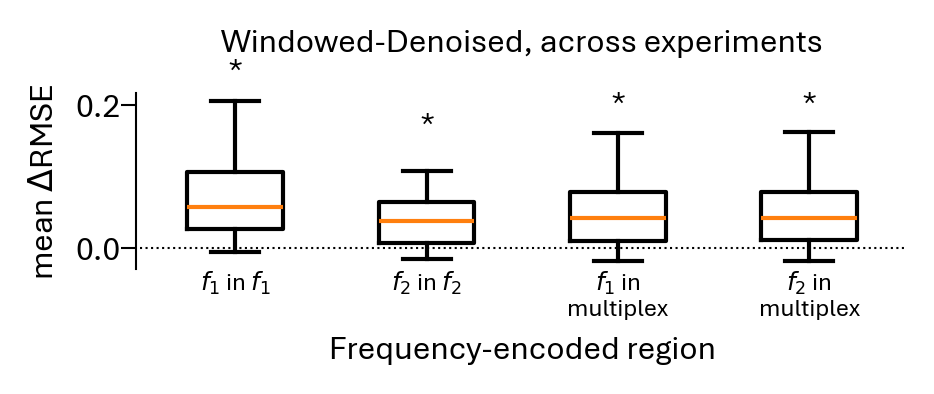

In [27]:
sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009", "Pilot001", "Pilot009", "Pilot010", "Pilot011"] + ["020"]*3+["021"]*3 + ["020"]*3+["021"]*3
mri_ids = ["3T", "3T", "3T", "3T", "3T", "3T", "3T", "3T", "3T", "7T", "7T", "7T", "7T"] + ["3T"]*6 + ["7T"]*6
task_ids = ["entrain"] * 9 + ["AttendAway"] * 4 + ["entrainA", "entrainB", "entrainC", "entrainD", "entrainE", "entrainF"] * 2

fig, ax = plt.subplots(figsize=(3,1.2), dpi=300, layout="constrained")

windowed_mean = []
denoised_mean = []
boxplot = []

for frequency_of_roi, frequency_of_interest in zip(["f1","f2","multiplex","multiplex"], ["f1","f2"]*2):
    count = 0
    _windowed_mean = []
    _denoised_mean = []
    _boxplot = []
    for sub_id, mri_id, task_id in zip(sub_ids, mri_ids, task_ids):
        raw_data = rmse_df[(rmse_df.task_id==task_id) & (rmse_df.mri_id==mri_id) & (rmse_df.sub_id==sub_id) & (rmse_df.ts_processing_step=="raw") & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest) & (rmse_df.task_same_as_roi_task)]
        windowed_data = rmse_df[(rmse_df.task_id==task_id) & (rmse_df.mri_id==mri_id) & (rmse_df.sub_id==sub_id) & (rmse_df.ts_processing_step=="windowed") & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest) & (rmse_df.task_same_as_roi_task)]
        denoised_data = rmse_df[(rmse_df.task_id==task_id) & (rmse_df.mri_id==mri_id) & (rmse_df.sub_id==sub_id) & (rmse_df.ts_processing_step=="denoised") & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest) & (rmse_df.task_same_as_roi_task)]
        denoisedrephased_data = rmse_df[(rmse_df.task_id==task_id) & (rmse_df.mri_id==mri_id) & (rmse_df.sub_id==sub_id) & (rmse_df.ts_processing_step=="denoisedrephased") & (rmse_df.frequency_of_roi==frequency_of_roi) & (rmse_df.frequency_of_interest==frequency_of_interest) & (rmse_df.task_same_as_roi_task)]

        for x_pos, _data in enumerate([windowed_data, denoised_data]):
            assert _data.shape == (1,10)
            _data = _data['rmse'].values[0]
            if x_pos == 0:
                X = _data
            else:
                X = np.vstack([X,_data])

        y1,y2=X.mean(1)
        mean_rmse_diff = y1-y2
        _windowed_mean.append(y1)
        _denoised_mean.append(y2)
        _boxplot.append(mean_rmse_diff)

    windowed_mean.append(_windowed_mean)
    denoised_mean.append(_denoised_mean)
    boxplot.append(_boxplot)

# Boxplot
box = ax.boxplot(boxplot, showfliers=False, whis=1.5, widths=linewidth)

# Add significance
q3_offset = .1
for i,_windowed,_denoised in zip(range(4),windowed_mean,denoised_mean):
    pval = wilcoxon(_windowed,_denoised).pvalue
    q1 = box['boxes'][i].get_ydata()[1]
    q3 = box['boxes'][i].get_ydata()[3]
    iqr = q3-q1
    ypos = (iqr*1.5 + q3)
    #ypos = q3
    pval_txt = "*"
    if pval >= .05:
        pval_txt = "n.s."
    ax.text(i+1, ypos, pval_txt, ha='center', va='bottom', fontsize=FONTSIZE)

for spine_type in ("top","right","bottom"):
    ax.spines[spine_type].set_visible(False)

ax.spines.left.set_linewidth(linewidth)
ax.spines.left.set_position(("outward", 1))
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["$f_1$ in $f_1$", "$f_2$ in $f_2$", "$f_1$ in\nmultiplex", "$f_2$ in\nmultiplex"], rotation=0, fontsize=FONTSIZE)
ax.set_xlabel("Frequency-encoded region", fontsize=FONTSIZE)

ax.set_ylabel("mean $\Delta$RMSE", fontsize=FONTSIZE)

ax.set_title(f"Windowed-Denoised, across experiments", fontsize=FONTSIZE, pad=10)
ax.axhline(0, color="k",linestyle="dotted", lw=.5,zorder=0) 
ax.tick_params(axis='y', which='both', labelsize=FONTSIZE, width=linewidth, pad=0)
ax.tick_params(axis='x', which='both', labelsize=FONTSIZE-2, width=linewidth, pad=0, length=0)

fig.savefig(MAIN / f"ExtFig1_changeRMSE_across_experiments.png", dpi=300)

In [ ]:
fontsize = 6
linewidth=.4
max_min = 1.2
vmin=-max_min
vmax=max_min
roi_c_dict = get_roi_colour_codes()
fig, ax_dict = plt.subplot_mosaic([["X"]], figsize=(3.2,1.5), dpi=300,layout="constrained")

ax=ax_dict["X"]
im = ax.imshow(y, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

# Cbar 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(
    ax, width="5%",height="25%",loc="center right",borderpad=-1
)
cbar = fig.colorbar(im, cax=axins)
cbar.outline.set_linewidth(linewidth)
cbar.ax.tick_params(axis='y', pad=0.4, length=2, width=linewidth, direction="in", which="both",colors='white')
cbar.set_ticks([vmin,0,vmax])
cbar.set_ticklabels([0 if i==0 else f"{i:.1f}" for i in [vmin,0,vmax]], fontsize=fontsize,c='k')
cbar.set_label("Z-scored $\Delta$BOLD",fontsize=fontsize)

for spine_type in ("top","right","left"):
    ax.spines[spine_type].set_visible(False)

ax.spines.bottom.set_linewidth(linewidth)
ax.spines.bottom.set_position(("outward", 1))
ax.set_yticks([])
ax.set_xticks([-.5,ax.get_xlim()[-1]/2,ax.get_xlim()[-1]])
start_tp = 39
ax.set_xticklabels([start_tp,600*.3/2,39+(599*.3)],fontsize=FONTSIZE)
ax.tick_params(axis="both",length=2,pad=0,width=linewidth,)
ax.set_title("BOLD across stimulus-locked vertices", fontsize=FONTSIZE)
ax.set_xlabel("Time (s)", fontsize=FONTSIZE)
ax.set_ylabel("Vertices", fontsize=FONTSIZE)
ax.set_xlim(-20,600)
ylim = ax.get_ylim()[0]
ax.set_ylim(ylim,-1*.1*ylim)
ax.fill_between(
    [0,1/_task_frequencies[0]/TR],
    [-1*(.1-.020)*ylim]*2,
    [-1*.1*ylim]*2,
    color=roi_c_dict["f1"]
)
ax.fill_between(
    [0,1/_task_frequencies[1]/TR],
    [-1*(.1-.05)*ylim]*2,
    [-1*(.1-.07)*ylim]*2,
    color=roi_c_dict["f2"]
)
ax.text(10/TR,-1*.1*ylim,"Timescale (s)",fontsize=FONTSIZE-1,ha='left',va='top')
ax.fill_between([-20,-5],[n_f1-.5,n_f1-.5],[-.5,-.5],color=roi_c_dict["f1"])
ax.fill_between([-20,-5],[n_f1+n_f1f2-.5]*2,[n_f1-.5]*2,color=roi_c_dict["f1f2"])
ax.fill_between([-20,-5],[n_f1+n_f1f2+n_f2-.5]*2,[n_f1+n_f1f2-.5]*2,color=roi_c_dict["f2"])

fig.savefig("C.png",dpi=600,bbox_inches="tight")